In [1]:
import numpy as np 
import pandas as pd 

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from glob import glob

from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *

In [2]:
lung_img_dir = '/content/drive/MyDrive/ZahidVai/Lung Segmentation/CXR_png/'
mask_img_dir = '/content/drive/MyDrive/ZahidVai/Lung Segmentation/masks/'


lung_img_dir_glob = '/content/drive/MyDrive/ZahidVai/Lung Segmentation/CXR_png/*.png'
mask_img_dir_glob = '/content/drive/MyDrive/ZahidVai/Lung Segmentation/masks/*.png'

lung_img = glob(lung_img_dir_glob)
mask_img = glob(mask_img_dir_glob)

In [3]:
len(lung_img), len(mask_img)

(800, 704)

In [4]:
lungs_filenames = [name.split('/')[-1].split('.png')[0] for name in lung_img]
import re
import cv2
lung_paths = []
mask_paths = []
for lungs_filename in lungs_filenames:
  for mask_filename in mask_img:
      mask_match = re.search(lungs_filename, mask_filename)
      if mask_match:
        lung_paths.append(os.path.join(lung_img_dir,f"{lungs_filename}.png"))
        mask_paths.append(mask_filename)

In [5]:
assert len(mask_paths) == len(lung_paths)
print(f'Total number of samples {len(lung_paths)}')

Total number of samples 704


In [6]:
X = np.zeros((len(lung_paths),256,256))
y = np.zeros((len(lung_paths),256,256))

In [7]:
# Convert images to gray, resize and normalize for NN
def transform_img(img):
  img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  reshape_img = cv2.resize(img_gray,img_shape)
  return reshape_img/255.0

In [8]:
# Loading images and masks
img_shape = (256,256)
for i, lung_path in tqdm(enumerate(lung_paths)):
    lung_img = cv2.imread(lung_path)
    X[i] = transform_img(lung_img)
for i , mask_path in tqdm(enumerate(mask_paths)):
    mask_img = cv2.imread(mask_path)
    y[i] = transform_img(mask_img)

704it [02:09,  5.42it/s]
704it [04:02,  2.91it/s]


In [9]:
def plot_mask(X,y):
  i,j = np.random.randint(0,len(X),2)
  plt.figure(figsize=(20,20))
  
  plt.subplot(121)
  plt.axis('off')
  plt.title('Chest X-ray with Mask')
  plt.imshow(np.hstack((X[i],y[i])), cmap = 'gray')
  plt.subplot(122)
  plt.axis('off')
  plt.title('Chest X-ray with Mask')
  plt.imshow(np.hstack((X[j],y[j])), cmap = 'gray')
  plt.savefig('sample.jpeg')
  plt.show()

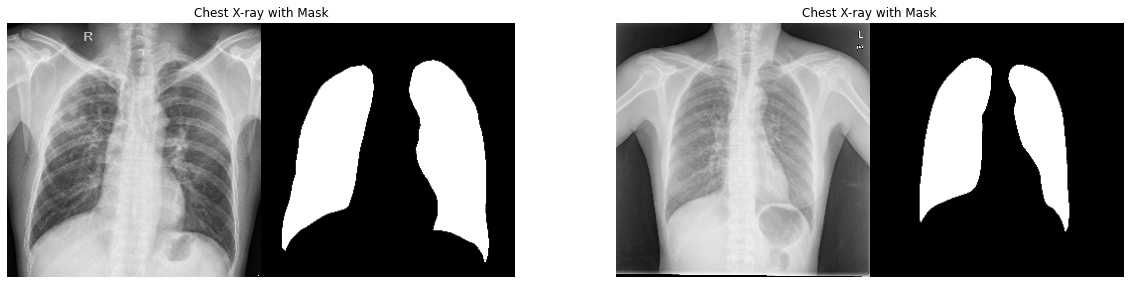

In [10]:
plot_mask(X,y)

In [11]:
def unet(input_size=(256,256,1)):
  inputs = Input(input_size)
  
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

  conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

  return Model(inputs=[inputs], outputs=[conv10])

In [12]:
model = unet(input_size=(256,256,1))

In [13]:
model.compile(optimizer=Adam(lr=5*1e-4), loss="binary_crossentropy",
                  metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="CloneZahidmodel_weight.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='loss',
                             save_best_only=True,
                             save_weights_only = True)


early = EarlyStopping(monitor="loss", 
                      patience=10)
callbacks_list = [checkpoint, early]

In [16]:
EPOCHS = 30
batch_size = 32
val_split = 0.2
history = model.fit(x = X,
                    y = y, 
                    validation_split = val_split, 
                    epochs = EPOCHS, 
                    batch_size = batch_size,
                    callbacks = callbacks_list
                    )

Epoch 1/30
18/18 [==============================] - 39s 1s/step - loss: 0.5885 - binary_accuracy: 0.7468 - val_loss: 0.5388 - val_binary_accuracy: 0.7429
Epoch 2/30
18/18 [==============================] - 10s 586ms/step - loss: 0.5486 - binary_accuracy: 0.7469 - val_loss: 0.4929 - val_binary_accuracy: 0.7429
Epoch 3/30
18/18 [==============================] - 10s 583ms/step - loss: 0.4932 - binary_accuracy: 0.7469 - val_loss: 0.5164 - val_binary_accuracy: 0.7429
Epoch 4/30
18/18 [==============================] - 11s 588ms/step - loss: 0.4479 - binary_accuracy: 0.7469 - val_loss: 1.0278 - val_binary_accuracy: 0.7429
Epoch 5/30
18/18 [==============================] - 11s 595ms/step - loss: 0.3787 - binary_accuracy: 0.7470 - val_loss: 0.8270 - val_binary_accuracy: 0.7431
Epoch 6/30
18/18 [==============================] - 11s 600ms/step - loss: 0.3119 - binary_accuracy: 0.8403 - val_loss: 1.2436 - val_binary_accuracy: 0.7457
Epoch 7/30
18/18 [==============================] - 11s 602ms

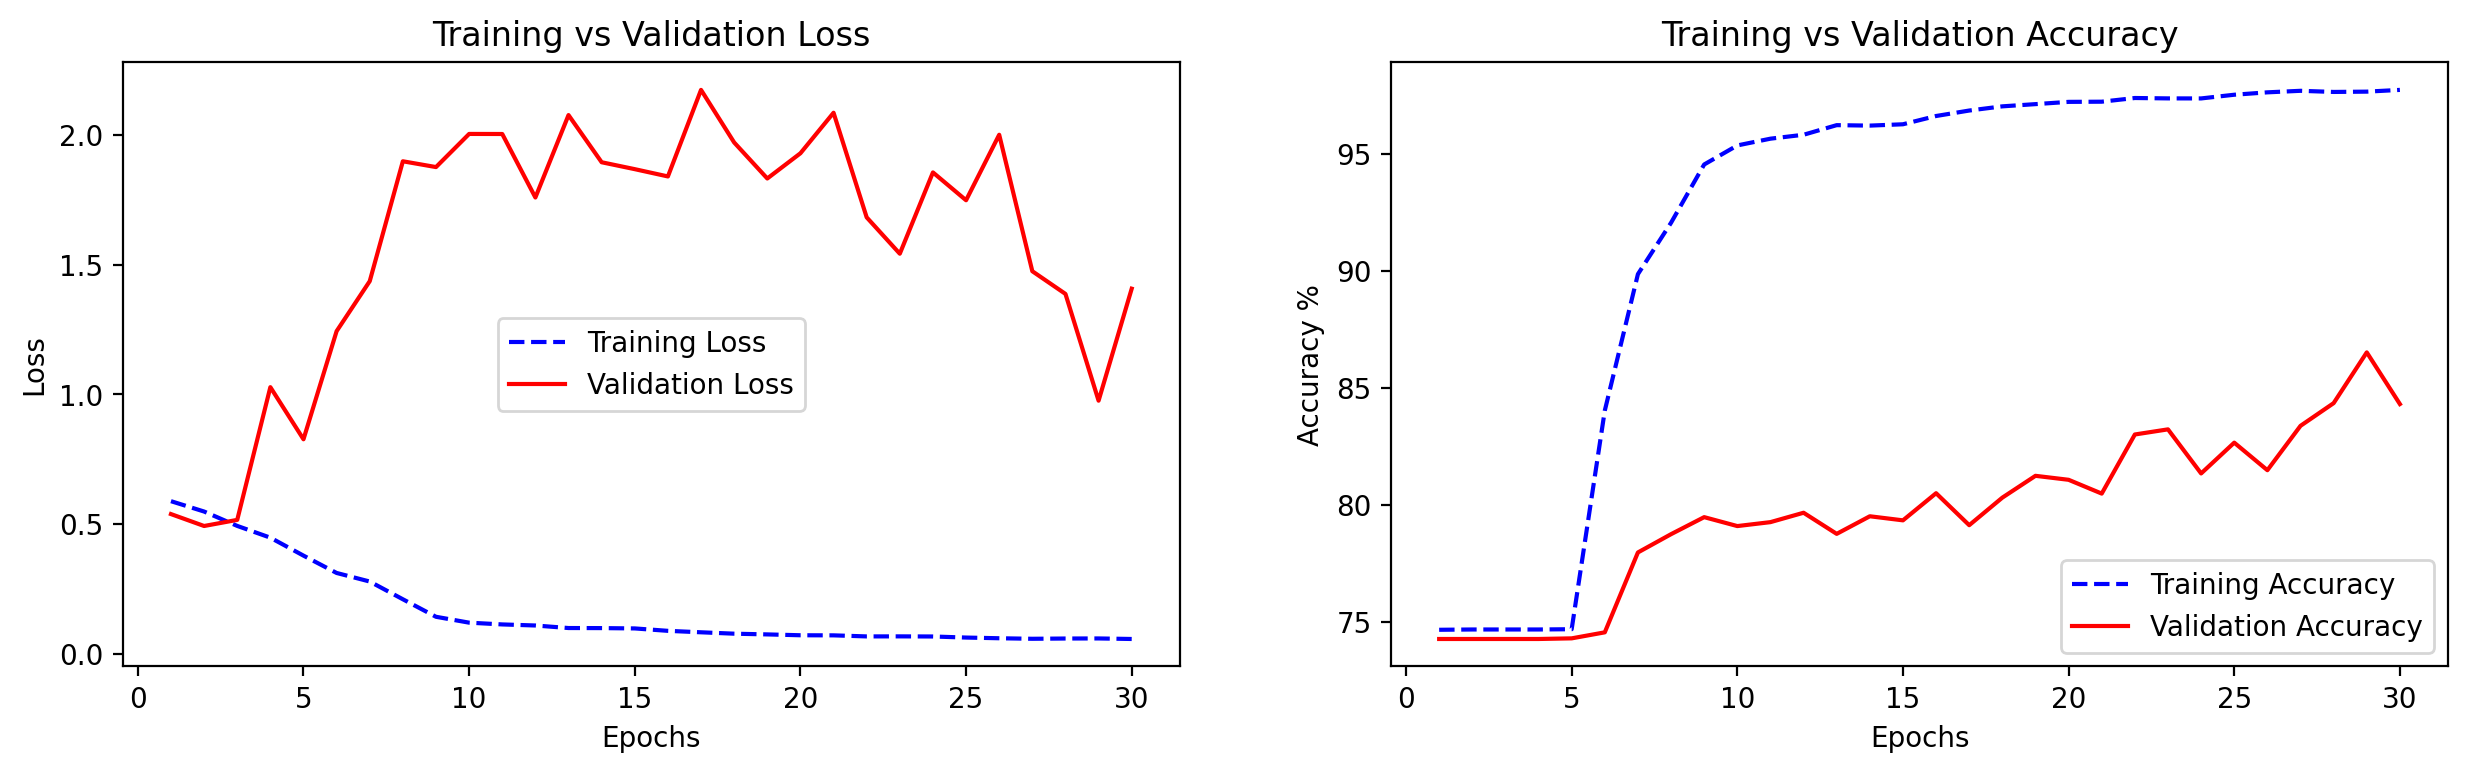

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4),dpi=200)

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

ax[0].plot(epoch_count, training_loss, 'b--')
ax[0].plot(epoch_count, validation_loss, 'r-')
ax[0].legend(['Training Loss', 'Validation Loss'])
ax[0].set_title('Training vs Validation Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')

ax[1].plot(epoch_count, 100* np.array(training_accuracy), 'b--')
ax[1].plot(epoch_count, 100 *np.array(validation_accuracy), 'r-')
ax[1].legend(['Training Accuracy', 'Validation Accuracy'])
ax[1].set_title('Training vs Validation Accuracy')
ax[1].set_ylabel('Accuracy %')
ax[1].set_xlabel('Epochs')
plt.savefig('CloneModel.jpeg')

In [18]:
test_dir = '/content/drive/MyDrive/ZahidVai/Lung Segmentation/test/*'
test_img = glob(test_dir)

In [19]:
def add_mask(img,mask):
  _ , mask = cv2.threshold(mask ,0.3,1,cv2.THRESH_BINARY)
  merged = cv2.addWeighted(img, 0.7, mask.astype(np.float64), 0.3, 0)
  return merged


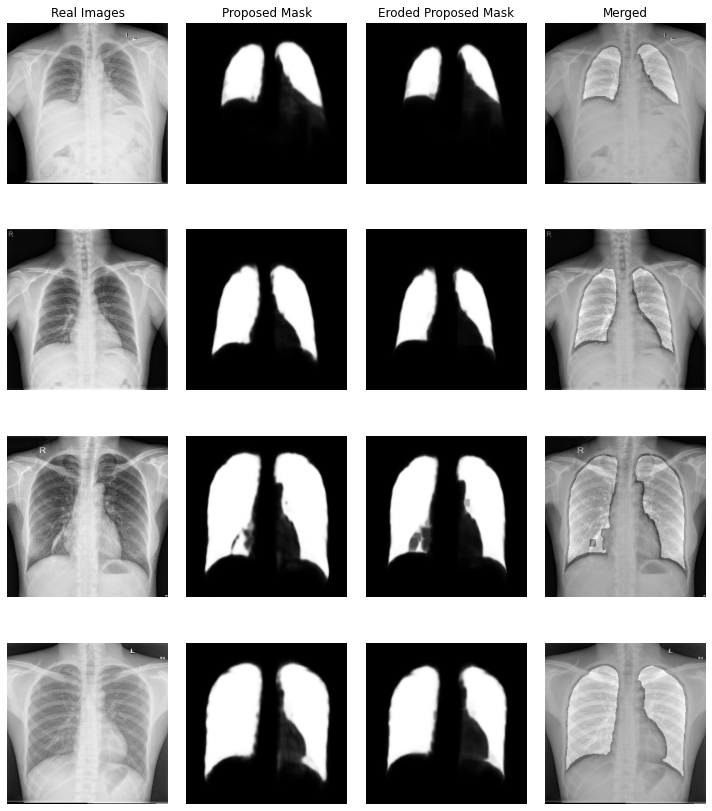

In [20]:
def plot_test(test_img,
              kernel =np.ones((5, 5),
                              np.uint8),
              save = False):
    size = 4
    test_size = len(test_img)
    test_sample = np.array(test_img)[np.random.randint(0, test_size, size).astype(int)]
    fig, axs = plt.subplots(nrows=size, ncols=4, figsize=(10, 12))
    cols = ['Real Images', 'Proposed Mask', 'Eroded Proposed Mask', 'Merged']
    
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
        
        
    axs = axs.ravel()
    
    for i in range(16):

        if i %4 == 0:
            
            img = cv2.imread(test_sample[i//4])
            img = transform_img(img)
            axs[i].imshow(img, cmap = 'gray')

        elif i %4 == 1:
            mask = model.predict(np.array([img]))
            axs[i].imshow(np.squeeze(mask[0]), cmap = 'gray')
        
        elif i %4 == 2:         
             erode_img = cv2.erode(mask[0], kernel, iterations=2) 
             axs[i].imshow(erode_img, cmap = 'gray')
        else:
             merged = add_mask(img, erode_img)
             axs[i].imshow(merged, cmap = 'gray')
        axs[i].axis('off')

    if save:
        plt.savefig('predicted_mask.jpeg')
    fig.tight_layout()
    plt.show()

kernel =  kernel =np.ones((5, 5), np.uint8)
plot_test(test_img, save =True)

In [21]:
model.save('/content/drive/MyDrive/ZahidVai/Lung Segmentation/Better_Segment_Model.h5')